In [1]:
import torch
import torchvision.datasets as datasets

device = torch.device('mps')

%load_ext autoreload
%autoreload 2

In [2]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [3]:
import numpy as np

##corrupt data
def corrupt_data(data):
    data[data>0.9] = 1
    data[data<0.9] = 0
    square_size = data.shape[-1]
    center_coord = np.random.randint(0,square_size,(2,data.shape[0]))
    square_size = np.repeat(np.random.randint(0,square_size//2,data.shape[0]).reshape(1,-1),2,axis=0)
    upper_left_coord = np.minimum(np.maximum(center_coord - (square_size//2),0),square_size)
    for i in range(data.shape[0]):
        data[i,:,upper_left_coord[0,i]:upper_left_coord[0,i]+square_size[0,i],upper_left_coord[1,i]:upper_left_coord[1,i]+square_size[1,i]] = -10
    return data

train_dataset = corrupt_data(train_dataset)
eval_dataset = corrupt_data(eval_dataset)

In [50]:
from pythae.models import IC_AE, IC_AEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist import Encoder_vAE_MNIST, Decoder_AE_MNIST
#from pythae.models.nn import Encoder_vAE

In [55]:
config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-4,
    batch_size=500,
    num_epochs=10, # Change this to train the model a bit more
)


model_config = IC_AEConfig(
    input_dim=(1, 28, 28),
    latent_dim=32
)

model = IC_AE(
    model_config=model_config
)
model = model.to(device)

In [36]:
model.nU = 5
model.beta = 1

In [56]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

In [57]:
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Preprocessing train data...
Preprocessing eval data...

Using Base Trainer

Model passed sanity check !

Created my_model/AE_training_2022-12-13_21-54-20. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Eval of epoch 1/10: 100%|████████████████████| 20/20 [00:08<00:00,  2.49batch/s]
--------------------------------------------------------------------------
Train loss: 120.31
Eval loss: 68.3116
--------------------------------------------------------------------------
Eval of epoch 2/10: 100%|████████████████████| 20/20 [00:07<00:00,  2.67batch/s]
--------------------------------------------------------------------------
Train loss: 59.8474
Eval loss: 55.393
--------------------------------------------------------------------------
Eval of epoch 3/10: 100%|████████████████████| 20/20 [00:07<00:00,  2.62batch/s]
--------------------------------------------------------------------------
Train loss: 53.1381
Eval loss: 50.9173
-----------

In [18]:
train_dataset[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [20]:
x = train_dataset[:10]
z = model.encoder(x).embedding
x_rec = model.decoder(z).reconstruction

In [26]:
!conda update matplotlib

Solving environment: - 

Updating matplotlib is constricted by 

anaconda -> requires matplotlib==3.5.1=py39hecd8cb5_1

If you are sure you want an update of your package either try `conda update --all` or install a specific version of the package you want using `conda install <pkg>=<version>`

done

## Package Plan ##

  environment location: /Users/louis/opt/anaconda3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.11.1              |   py39hecd8cb5_3         941 KB
    conda-package-handling-1.9.0|   py39hca72f7f_1         1.5 MB
    pyjwt-2.4.0                |   py39hecd8cb5_0          35 KB
    ruamel.yaml-0.17.21        |   py39hca72f7f_0         179 KB
    ruamel.yaml.clib-0.2.6     |   py39hca72f7f_1         126 KB
    ------------------------------------------------------------
                                           Tota

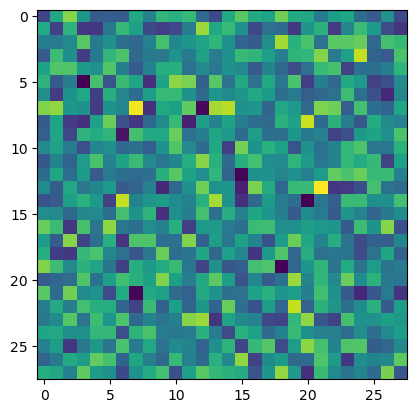

In [33]:
import matplotlib.pyplot as plt
plt.imshow(x_rec[3].detach()[0])

In [31]:
print(z)

tensor([[ 0.0246,  0.0197, -0.0422,  ...,  0.0372,  0.0016, -0.0013],
        [ 0.0246,  0.0197, -0.0422,  ...,  0.0372,  0.0016, -0.0013],
        [ 0.0277,  0.0211, -0.0342,  ...,  0.0384,  0.0036,  0.0015],
        ...,
        [ 0.0246,  0.0197, -0.0422,  ...,  0.0372,  0.0016, -0.0013],
        [ 0.0216,  0.0195, -0.0413,  ...,  0.0346,  0.0059, -0.0026],
        [ 0.0244,  0.0198, -0.0424,  ...,  0.0371,  0.0013, -0.0014]],
       grad_fn=<AddmmBackward0>)


In [ ]:
import os
from pythae.models import AutoModel

In [ ]:
last_training = sorted(os.listdir('my_model'))[-1]
trained_model = AutoModel.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

In [ ]:
from pythae.samplers import NormalSampler

In [ ]:
# create normal sampler
normal_samper = NormalSampler(
    model=trained_model
)

In [ ]:
# sample
gen_data = normal_samper.sample(
    num_samples=25
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# show results with normal sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [ ]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

In [ ]:
# set up GMM sampler config
gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

# create gmm sampler
gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

# fit the sampler
gmm_sampler.fit(train_dataset)

In [ ]:
# sample
gen_data = gmm_sampler.sample(
    num_samples=25
)

In [ ]:
# show results with gmm sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## ... the other samplers work the same

## Visualizing reconstructions

In [ ]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

In [ ]:
# show reconstructions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [ ]:
# show the true data
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(eval_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## Visualizing interpolations

In [ ]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

In [ ]:
# show interpolations
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)